<a href="https://colab.research.google.com/github/nfreundlich/CS445_CourseProject/blob/master/CS445_CourseProject_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS445 - Class project

In [201]:
!python --version

Python 3.7.1


In [202]:
import cv2
import numpy as np
from scipy import sparse as sparse
from scipy.sparse import linalg as linalg
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
import os
import time
import scipy
import pandas as pd
import skimage
from skimage import metrics

## Image colorization

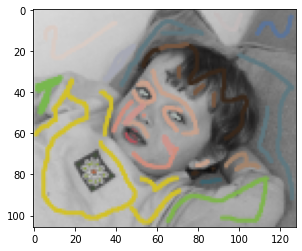

In [203]:
img_bgr = (cv2.imread('samples/boy_annotated2.png') / 255.0)

img = cv2.cvtColor(img_bgr.astype('float32'), cv2.COLOR_BGR2RGB)
img_yuv = cv2.cvtColor(img.astype('float32'), cv2.COLOR_RGB2YUV)

plt.imshow(img, cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(106, 128, 3)


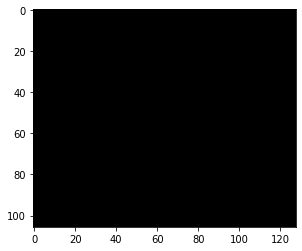

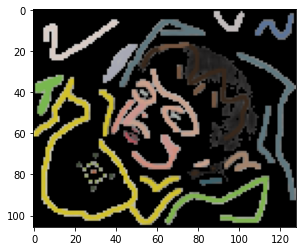

In [204]:
h, w, c = img.shape

color_mask = np.ones((h, w, 3)) * -999

print(color_mask.shape)
plt.figure()
plt.imshow(cv2.cvtColor(color_mask.astype('float32'), cv2.COLOR_YUV2RGB))

for y in range(h):
    for x in range(w):
        # If pixel is not gray (i.e. R=G=B) copy pixel to color mask
        if img[y, x, 0] != img[y, x, 1] or img[y, x, 0] != img[y, x, 2] or img[y, x, 1] != img[y, x, 2]:
            color_mask[y, x, :] = img_yuv[y, x, :]

plt.figure()

plt.imshow(cv2.cvtColor(color_mask.astype('float32'), cv2.COLOR_YUV2RGB))

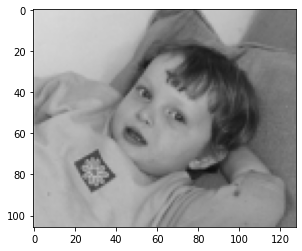

In [205]:
img_bgr = cv2.imread('samples/boy_original_grayscale2.png') / 255.0

img = cv2.cvtColor(img_bgr.astype('float32'), cv2.COLOR_BGR2RGB)
img_grayscale_yuv = cv2.cvtColor(img.astype('float32'), cv2.COLOR_RGB2YUV)

plt.figure()

plt.imshow(cv2.cvtColor(img_grayscale_yuv.astype('float32'), cv2.COLOR_YUV2RGB))

In [206]:
def calc_mu_var(window, circle_mask):
    """
    Compute mean and variance of a window, cropped by a circle mask.
    """
    masked_window = window * circle_mask

    mu = masked_window.sum() / circle_mask.sum()
    mu_circle = mu * circle_mask
    var = (((masked_window - mu_circle)**2 ).sum())/ circle_mask.sum()

    return mu, var

In [207]:
def colorize(im_yuv, color_mask, n = 10):
    """
    Colorize an image given its representation in yuv space and a color map.
    
    @param im_yub: image to colorize in yuv space
    @param color_mask: colorized mask
    @param n: take circle with radius n around current pixel
    
    @return: colorized image in rgb
    """
    
    im_h, im_w, colors = im_yuv.shape
    
    out_img_yuv = np.zeros((im_h, im_w, 3))
    out_img_yuv[:, :, 0] = im_yuv[:, :, 0].copy()
    
    im2var = np.arange(im_h * im_w).reshape(im_w, im_h).T

    # Create mask with full circle (this will be cropped later for edge pixels)
    full_circle_mask = np.zeros((n*2+1, n*2+1))
    for yy in range(n*2+1):
        for xx in range(n*2+1):
            dist2 = (yy-n) ** 2 + (xx-n) ** 2
            if dist2 <= n ** 2:
                full_circle_mask[yy, xx] = 1

    A_rows = []
    A_cols = []
    A_data = [] 
    b = np.zeros((im_h * im_w * 2))
    e = 0
    
    # Loop over U and V colors (U=1, V=2)
    for c in range(1, 3, 1):
        # For V channel, keep existing equations based on weighted intensities, truncate lists to remove
        # constraints based on U given colors
        if c == 2:
            A_rows = A_rows[0: A_data_len]
            A_cols = A_cols[0: A_data_len]
            A_data = A_data[0: A_data_len]
            e = im_h * im_w
        else:  
            for y in range(im_h):
                for x in range(im_w):  
                    min_y = y - n
                    max_y = y + n
                    min_x = x - n
                    max_x = x + n
                    
                    window_center_yy = n
                    window_center_xx = n

                    circle_mask = full_circle_mask.copy()

                    # Check for overlap of image edge and adjust window size and circle mask if necessary
                    if min_y < 0:
                        circle_mask = circle_mask[(0-min_y):, :]
                        window_center_yy = n + min_y
                        min_y = 0
                    if max_y > im_h-1:
                        circle_mask = circle_mask[0:(2*n+im_h-max_y), :]
                        max_y = im_h-1 
                    if min_x < 0:
                        circle_mask = circle_mask[:, (0-min_x):]
                        window_center_xx = n + min_x
                        min_x = 0
                    if max_x > im_w-1:
                        circle_mask = circle_mask[:, 0:(2*n+im_w-max_x)]
                        max_x = im_w-1

                    window = im_yuv[min_y:max_y+1, min_x:max_x+1, 0].copy()

                    window_h, window_w = window.shape
                    w = np.zeros(window.shape)
                    mu, var = calc_mu_var(window, circle_mask)

                    if var > 0:
                        # Equation 2
                        w = np.exp(-((im_yuv[y, x, 0] - im_yuv[min_y:max_y+1, min_x:max_x+1, 0])**2) / (2 * var))
                        # Equation 3
                        #w = 1 + (1/var) * (im_yuv[y, x, 0] - mu) * (im_yuv[min_y:max_y+1, min_x:max_x+1, 0] - mu)
                    else:
                        w = np.ones(window.shape)

                    w[window_center_yy, window_center_xx] = 0
                    
                    w = w * circle_mask

                    sum_weights = w.sum()
                    w = w / sum_weights

                    A_rows.append(e)
                    A_cols.append(im2var[y, x])
                    A_data.append(1)
                    for yy in range(window_h):
                        for xx in range(window_w):
                                # If not center point of window
                                if y != min_y + yy or x != min_x + xx:
                                    A_rows.append(e)
                                    A_cols.append(im2var[min_y + yy, min_x + xx])
                                    A_data.append(-w[yy, xx])
                    b[e] = 0
                    e += 1
                    A_data_len = len(A_data)
                    
        # Set constraints for given colors
        for y in range(im_h):
            for x in range(im_w):
                if color_mask[y, x, c] > -999:
                    A_rows.append(e)
                    A_cols.append(im2var[y, x])
                    A_data.append(1)
                    b[e] = color_mask[y, x, c]
                    e += 1
                    
        # Trim b to fit number of equations
        b = b[0:e]
        A_csr = sparse.csr_matrix((A_data, (A_rows, A_cols)), shape = (e, im_h * im_w))
        v = linalg.lsqr(A_csr, b, atol=1e-13, btol=1e-13)[0]
    
        out_img_yuv[:, :, c] = v.reshape(im_w, im_h).T

    return cv2.cvtColor(out_img_yuv.astype('float32'), cv2.COLOR_YUV2RGB)

Starting colorization...
Elapsed time:  11.907315254211426
0.033965576 0.91039324


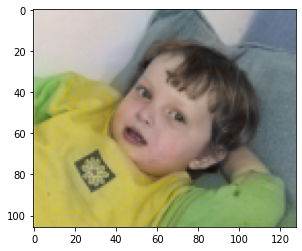

In [208]:
import time
print("Starting colorization...")
start = time.time()
im_out = colorize(img_grayscale_yuv, color_mask)
end = time.time()
print("Elapsed time: ", end - start)

print(im_out.min(), im_out.max())
plt.figure()

plt.imshow(im_out, cmap="gray")

In [209]:
def compare_images_metrics(img, gt):
    """
    Compare two images
    
    @param img: image to compare
    @param gt: ground truth (color image)
    
    @return: (structural similarity, mean squared error, peak noise to signal ratio)
    """
    img_float_64 = skimage.img_as_float64(img)
    gt_float_64 = skimage.img_as_float64(gt)
    
    ssim = skimage.metrics.structural_similarity(img_float_64, gt_float_64, multichannel=True)
    mse = skimage.metrics.mean_squared_error(img_float_64, gt_float_64)
    pnsr = skimage.metrics.peak_signal_noise_ratio(img_float_64, gt_float_64)
    return (ssim, mse, pnsr)

In [210]:
def compare_images_measure(img, gt):
    """
    Compare two images
    
    @param img: image to compare
    @param gt: ground truth (color image)
    
    @return: (structural similarity, mean squared error, peak noise to signal ratio)
    """
    ssim = skimage.measure.compare_ssim(img, gt, multichannel=True)
    mse = skimage.measure.compare_mse(img, gt)
    pnsr = skimage.measure.compare_psnr(img, gt)
    return (ssim, mse, pnsr)

In [211]:
def colorize_fullstack_divide_in_squares(filename_bw = 'samples/boy_original_grayscale2.png', 
                                         filename_annotated = 'samples/boy_annotated2.png',
                                         recolorize_mode = False):
    """
    TODO
    """
    start = time.time()
    
    n = 10
    i = 0
    
    # TODO: avoid opening the files several times
    img_bgr = (cv2.imread(filename_annotated) / 255.0)
    img = cv2.cvtColor(img_bgr.astype('float32'), cv2.COLOR_BGR2RGB)
    im_yuv = cv2.cvtColor(img.astype('float32'), cv2.COLOR_RGB2YUV)
    h, w, c = img_bgr.shape
    original_h = h
    original_w = w
    
    print("Main image shape: ", w, 'x', h)
    
    # initialize main image
    main_image_out = np.zeros((h, w, 3))
    main_image_out[:, :, 0] = im_yuv[:, :, 0].copy()
    main_image_out_yuv = np.zeros((h, w, 3))
    
    # Read annotated file
    img_bgr_original = (cv2.imread(filename_annotated) / 255.0)
    img_annotated = img_bgr_original.copy()
    
    x0 = 0
    y0 = 0
         
    step_size = 100
    overlap = 2

    while y0 + step_size < original_h:
        if y0 + step_size * 2 < original_h:
            y1 = y0 + step_size
        else:
            y1 = original_h
            
        while x0 + step_size < original_w:
            if x0 + step_size * 2 < original_w:
                x1 = x0 + step_size
            else:
                x1 = original_w
    
            # annotations
            if recolorize_mode == False:
                img_bgr = img_bgr_original.copy() # annotated image
                h, w, c = img_bgr.shape
                img_bgr = img_bgr[y0:y1, x0:x1, :]           
                img = cv2.cvtColor(img_bgr.astype('float32'), cv2.COLOR_BGR2RGB)
                img_yuv = cv2.cvtColor(img.astype('float32'), cv2.COLOR_RGB2YUV)

                # Determine a mask
                h, w, c = img.shape
                color_mask = np.ones((h, w, 3)) * -999

                # Take the colors from overlapping patches
                if y0 != 0:
                    for y in range(0, overlap):
                        for x in range(0, w):
                            color_mask[y, x, :] = main_image_out_yuv[y0+y, x0 + x, :]

                if x0 != 0:
                    for y in range(0, h):
                        for x in range(0, overlap):
                            color_mask[y, x, :] = main_image_out_yuv[y0+y, x0 + x, :]
            
                for y in range(h):
                    for x in range(w):
                        # If pixel is white
                        if img[y, x, 0] != img[y, x, 1] or \
                           img[y, x, 0] != img[y, x, 2] or \
                           img[y, x, 1] != img[y, x, 2]:
                            color_mask[y, x, :] = img_yuv[y, x, :]
                            
            else: # recolorize mode
                # TODO: refactor here
                        
                file_path_annotations = filename_annotated #'samples_recolorize/recolor_boy_annotations.png'# 'samples_recolorize/MagrittePipe_annotations_2.jpg'
                file_path_color_image = filename_bw #'samples_recolorize/recolor_boy.png'# 'samples_recolorize/MagrittePipe.jpg'
                
                img_bgr_nfr_annotations = (cv2.imread(file_path_annotations) / 255.0)
                img_nfr_annotations = cv2.cvtColor(img_bgr_nfr_annotations.astype('float32'), cv2.COLOR_BGR2RGB)
                img_yuv_nfr_annotations = cv2.cvtColor(img_nfr_annotations.astype('float32'), cv2.COLOR_RGB2YUV)

                img_bgr_color_nfr = (cv2.imread(file_path_color_image) / 255.0)
                img_color_nfr = cv2.cvtColor(img_bgr_color_nfr.astype('float32'), cv2.COLOR_BGR2RGB)
                img_yuv_color_nfr = cv2.cvtColor(img_color_nfr.astype('float32'), cv2.COLOR_RGB2YUV)


                masked_annotation_nfr = np.abs(img_nfr_annotations - img_color_nfr)
                masked_annotation_nfr = masked_annotation_nfr[y0:y1, x0:x1, :]
                
                h, w, c = masked_annotation_nfr.shape

                color_mask = np.ones((h, w, 3)) * -999
                
                for y in range(h):
                    for x in range(w):
                        # white colors are preserved
                        if  (img_nfr_annotations[y + y0, x + x0, 0] ) == 1.0 and \
                            (img_nfr_annotations[y + y0, x + x0, 1] ) == 1.0 and \
                            (img_nfr_annotations[y + y0, x + x0, 2] ) == 1.0:
                                color_mask[y, x, :] = img_yuv_color_nfr[y + y0, x + x0, :]
                        else:
                        # TODO: use smaller value
                            if masked_annotation_nfr[y, x, 0] > 0.01 or \
                               masked_annotation_nfr[y, x, 1] > 0.01 or \
                               masked_annotation_nfr[y, x, 2] > 0.01:
                                color_mask[y, x, :] = img_yuv_nfr_annotations[y + y0, x + x0, :]

                plt.figure()
                plt.imshow(cv2.cvtColor(color_mask.astype('float32'), cv2.COLOR_YUV2RGB)) 


            img_bgr = cv2.imread(filename_bw) / 255.0
            img_bgr = img_bgr[y0:y1, x0:x1, :]
            img = cv2.cvtColor(img_bgr.astype('float32'), cv2.COLOR_BGR2RGB)
            img_grayscale_yuv = cv2.cvtColor(img.astype('float32'), cv2.COLOR_RGB2YUV)
                 
            # colorize image
            #if recolorize_mode == False:
            im_out = colorize(img_grayscale_yuv, color_mask, n)
            #else:
            #    im_out = re_colorize(img_grayscale_yuv, color_mask, n)
                
            main_image_out[y0:y1, x0:x1, :] = im_out
            main_image_out_yuv = cv2.cvtColor(main_image_out.astype('float32'), cv2.COLOR_RGB2YUV).copy()
            
            x0 += step_size - overlap
        x0 = 0
        y0 += (step_size - overlap)

    # clipping image
    im_out = np.clip(im_out, 0.0, 1.0)
        
    end = time.time()
    elapsed = end - start
    print("Total elapsed time: ", elapsed)
    
    return main_image_out

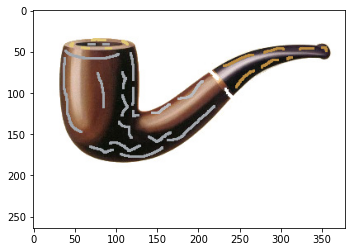

In [212]:
img_bgr = (cv2.imread('samples_recolorize/MagrittePipe_annotations_2.jpg') / 255.0)

img = cv2.cvtColor(img_bgr.astype('float32'), cv2.COLOR_BGR2RGB)
img_yuv = cv2.cvtColor(img.astype('float32'), cv2.COLOR_RGB2YUV)

plt.imshow(img, cmap="gray")

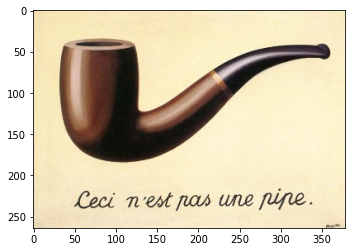

In [213]:
img_bgr_color = (cv2.imread('samples_recolorize/MagrittePipe.jpg') / 255.0)

img_color = cv2.cvtColor(img_bgr_color.astype('float32'), cv2.COLOR_BGR2RGB)
img_yuv_color = cv2.cvtColor(img_color.astype('float32'), cv2.COLOR_RGB2YUV)

plt.imshow(img_color, cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


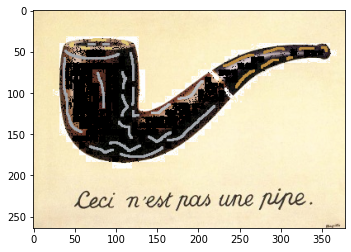

In [222]:
file_path_annotations = 'samples_recolorize/MagrittePipe_annotations_2.jpg'
file_path_color_image = 'samples_recolorize/MagrittePipe.jpg'

img_bgr_nfr_annotations = (cv2.imread(file_path_annotations) / 255.0)
img_nfr_annotations = cv2.cvtColor(img_bgr_nfr_annotations.astype('float32'), cv2.COLOR_BGR2RGB)
img_yuv_nfr_annotations = cv2.cvtColor(img_nfr_annotations.astype('float32'), cv2.COLOR_RGB2YUV)

img_bgr_color_nfr = (cv2.imread(file_path_color_image) / 255.0)
img_color_nfr = cv2.cvtColor(img_bgr_color_nfr.astype('float32'), cv2.COLOR_BGR2RGB)
img_yuv_color_nfr = cv2.cvtColor(img_color_nfr.astype('float32'), cv2.COLOR_RGB2YUV)

h, w, c = img_bgr_nfr_annotations.shape

color_mask = np.ones((h, w, 3)) * -999
masked_annotation_nfr = np.abs(img_nfr_annotations - img_color_nfr)

for y in range(h):
    for x in range(w):
        # white colors are preserved
        if  (img_nfr_annotations[y, x, 0] ) == 1.0 and \
            (img_nfr_annotations[y, x, 1] ) == 1.0 and \
            (img_nfr_annotations[y, x, 2] ) == 1.0:
                color_mask[y, x, :] = img_yuv_color_nfr[y, x, :]
        else:
        # TODO: use smaller value
            if masked_annotation_nfr[y, x, 0] > 0.01 or \
               masked_annotation_nfr[y, x, 1] > 0.01 or \
               masked_annotation_nfr[y, x, 2] > 0.01:
                color_mask[y, x, :] = img_yuv_nfr_annotations[y, x, :]
            
plt.figure()
plt.imshow(cv2.cvtColor(color_mask.astype('float32'), cv2.COLOR_YUV2RGB))

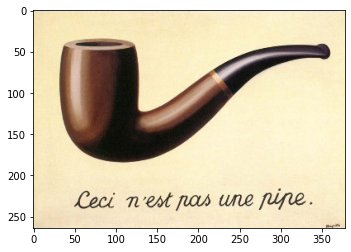

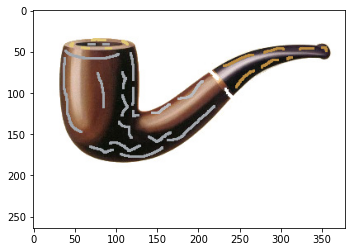

In [223]:
plt.figure()
plt.imshow(cv2.cvtColor(img_yuv_color_nfr.astype('float32'), cv2.COLOR_YUV2RGB), cmap="gray")

plt.figure()
plt.imshow(img_nfr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


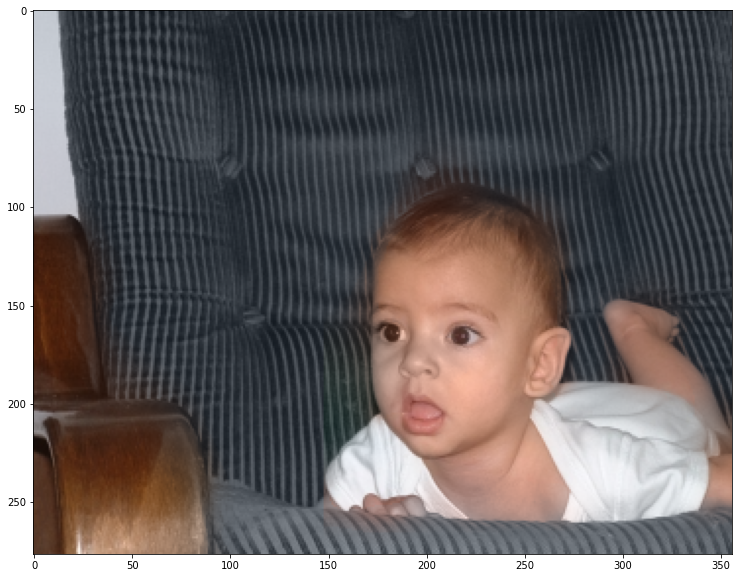

In [174]:
if True:
    im_out_5 = colorize_fullstack_divide_in_squares(filename_bw = 'samples_recolorize/chair.png',
                                        filename_annotated = 'samples_recolorize/chair_annotated.png',
                                        recolorize_mode = True)
    plt.figure(figsize=(20,10))
    plt.imshow(im_out_5, cmap="gray")